<a href="https://colab.research.google.com/github/heiliaavola/chemical-analysis-quantification/blob/main/ML_projekt_Selene_ja_Heili.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Esimene katsetus

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Load the data
file_path = 'data_ready_231029.xlsx'
data = pd.read_excel(file_path)

# Remove rows with missing values
cleaned_data = data.dropna()

# Group data by lab and compound
grouped_data_lab_compound = cleaned_data.groupby(['lab', 'compound'])

# Group data by compound
grouped_data_compound = cleaned_data.groupby('compound')

In [ ]:
cleaned_data

,lab,compound,sample_type,RT,sample,peak_area,note,c_real_M
0,L1,Amitrole,cal,0.72,cal1,2.856002e+08,non-linear,6.250000e-06
1,L1,Amitrole,cal,0.72,cal2,1.030577e+08,non-linear,2.580000e-06
2,L1,Amitrole,cal,0.72,cal3,6.593301e+07,non-linear,1.340000e-06
3,L1,Amitrole,cal,0.72,cal4,3.805867e+07,non-linear,7.780000e-07
4,L1,Amitrole,cal,0.72,cal5,1.340538e+07,linear,2.350000e-07
...,...,...,...,...,...,...,...,...
3933,L26,Vancomycin_H2,cal,2.92,cal2,2.533672e+05,linear,1.220000e-07
3934,L26,Vancomycin_H2,cal,2.92,cal3,1.262189e+05,linear,6.190000e-08
3935,L26,Vancomycin_H2,cal,2.92,cal4,7.662528e+04,linear,3.790000e-08
3936,L26,Vancomycin_H2,cal,2.92,cal5,2.222568e+04,linear,1.250000e-08


In [ ]:
# Function to split each group into training and test sets
def train_test_split_groups(groups, test_size=0.3, min_samples_for_split=3):
    train_test_split_data = []
    for group in groups:
        X = group['c_real_M'].values.reshape(-1, 1)
        y = group['peak_area'].values

        if len(X) >= min_samples_for_split:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
        else:
            X_train, X_test, y_train, y_test = X, np.array([]).reshape(-1, 1), y, np.array([])

        train_test_split_data.append((X_train, X_test, y_train, y_test))
    return train_test_split_data

In [ ]:
# Perform train-test split
train_test_split_lab_compound = train_test_split_groups([grouped_data_lab_compound.get_group(x) for x in grouped_data_lab_compound.groups])
train_test_split_compound = train_test_split_groups([grouped_data_compound.get_group(x) for x in grouped_data_compound.groups])

In [ ]:
# Function to perform linear regression and calculate MSE
def linear_regression_and_calculate_mse(train_test_data):
    results = []
    for X_train, X_test, y_train, y_test in train_test_data:
        if len(X_train) > 0 and len(X_test) > 0:
            model = LinearRegression()
            model.fit(X_train, y_train)
            y_pred_test = model.predict(X_test)
            mse = mean_squared_error(y_test, y_pred_test)
            slope = model.coef_[0]
            intercept = model.intercept_
            results.append((model, slope, intercept, mse))
        else:
            results.append((None, None, None, None))
    return results

In [ ]:
# Apply linear regression
results_lab_compound = linear_regression_and_calculate_mse(train_test_split_lab_compound)
results_compound = linear_regression_and_calculate_mse(train_test_split_compound)

In [ ]:
# Visualization function
def plot_linear_regression_results(group, result, group_label):
    model, slope, intercept, mse = result
    if model is not None:
        plt.scatter(group['c_real_M'], group['peak_area'], label='Data Points')
        line_X = np.linspace(group['c_real_M'].min(), group['c_real_M'].max(), 100).reshape(-1, 1)
        line_y = model.predict(line_X)
        plt.plot(line_X, line_y, color='red', label=f'Linear Regression (MSE: {mse:.2f})')
        plt.xlabel('Concentration')
        plt.ylabel('Peak Area')
        plt.title(f'Linear Regression for {group_label}')
        plt.legend()
        plt.show()

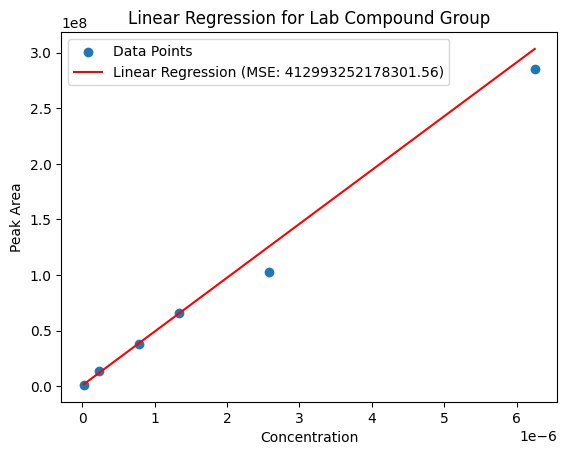

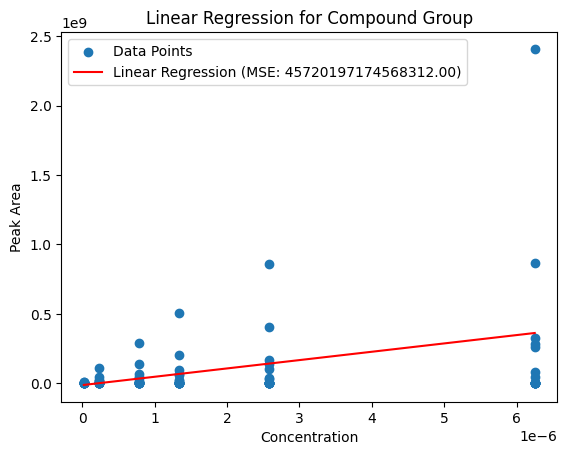

In [ ]:
# Example: Visualize for the first group of each dataset
plot_linear_regression_results([grouped_data_lab_compound.get_group(x) for x in grouped_data_lab_compound.groups][0], results_lab_compound[0], 'Lab Compound Group')
plot_linear_regression_results([grouped_data_compound.get_group(x) for x in grouped_data_compound.groups][0], results_compound[0], 'Compound Group')

In [ ]:
# Filtering the data for the specific compound 'Emamectin_B1a'
emamectin_b1a_data = cleaned_data[cleaned_data['compound'] == 'Emamectin_B1a']

# Separating the linear and non-linear data
emamectin_b1a_linear = emamectin_b1a_data[emamectin_b1a_data['note'] == 'linear']
emamectin_b1a_non_linear = emamectin_b1a_data[emamectin_b1a_data['note'] == 'non-linear']

# Perform linear regression for linear and non-linear data
def linear_regression(data):
    X = data['c_real_M'].values.reshape(-1, 1)
    y = data['peak_area'].values
    model = LinearRegression()
    model.fit(X, y)
    return model

model_linear = linear_regression(emamectin_b1a_linear)
model_non_linear = linear_regression(emamectin_b1a_non_linear)

# Visualization
plt.figure(figsize=(10, 6))

# Plot linear data points
plt.scatter(emamectin_b1a_linear['c_real_M'], emamectin_b1a_linear['peak_area'], color='blue', label='Linear Data Points')

# Plot non-linear data points
plt.scatter(emamectin_b1a_non_linear['c_real_M'], emamectin_b1a_non_linear['peak_area'], color='green', label='Non-Linear Data Points')

# Add regression line for linear data
line_X = np.linspace(emamectin_b1a_linear['c_real_M'].min(), emamectin_b1a_linear['c_real_M'].max(), 100).reshape(-1, 1)
line_y = model_linear.predict(line_X)
plt.plot(line_X, line_y, color='red', label='Linear Regression (Linear Data)')

# Add regression line for non-linear data
line_X_nl = np.linspace(emamectin_b1a_non_linear['c_real_M'].min(), emamectin_b1a_non_linear['c_real_M'].max(), 100).reshape(-1, 1)
line_y_nl = model_non_linear.predict(line_X_nl)
plt.plot(line_X_nl, line_y_nl, color='orange', label='Linear Regression (Non-Linear Data)')

# Add labels, title, and legend
plt.xlabel('Concentration (c_real_M)')
plt.ylabel('Peak Area')
plt.title('Linear Regression Analysis for Emamectin_B1a')
plt.legend()
plt.show()

Teine katsetus: ühe labori kõik mõõtmised ühe aine kohta

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [ ]:
# Load the data
file_path = 'data_ready_231029.xlsx'
data = pd.read_excel(file_path)

# Group data and aggregate lists
grouped_data = data.groupby(['lab', 'compound']).agg({'peak_area': lambda x: x.tolist(),
                                                      'c_real_M': lambda x: x.tolist(),
                                                      'note': lambda x: x.tolist()}).reset_index()

# Filter for Emamectin_B1a
emamectin_b1a_data = data[data['compound'] == 'Emamectin_B1a']

# Separate linear and non-linear data
emamectin_b1a_linear = emamectin_b1a_data[emamectin_b1a_data['note'] == 'linear']
emamectin_b1a_non_linear = emamectin_b1a_data[emamectin_b1a_data['note'] == 'non-linear']

In [ ]:
# Linear Regression Function
def perform_linear_regression(X, y):
    model = LinearRegression()
    model.fit(X, y)
    return model

# Perform regression for linear and non-linear data
model_linear = perform_linear_regression(emamectin_b1a_linear['c_real_M'].values.reshape(-1, 1),
                                         emamectin_b1a_linear['peak_area'].values)
model_non_linear = perform_linear_regression(emamectin_b1a_non_linear['c_real_M'].values.reshape(-1, 1),
                                             emamectin_b1a_non_linear['peak_area'].values)

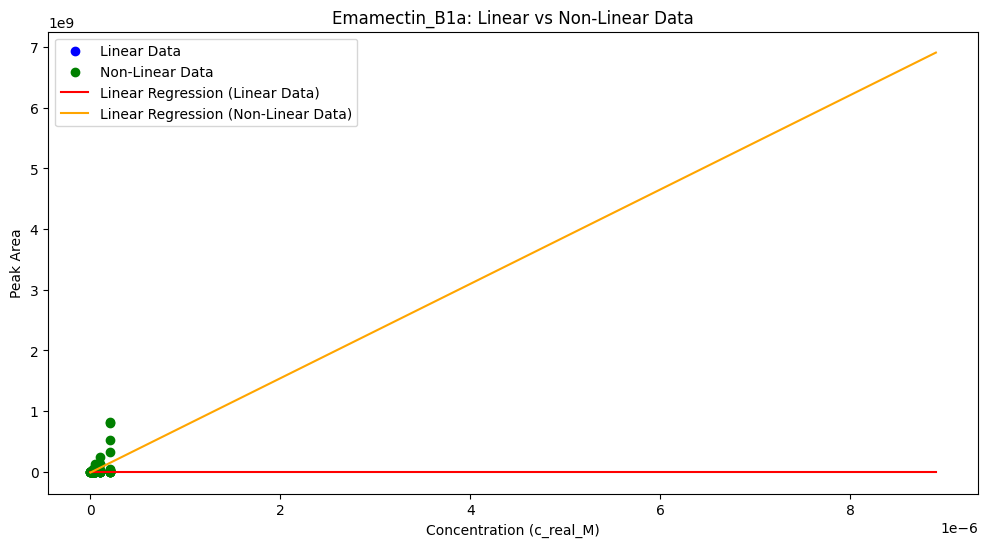

In [ ]:
# Visualization
plt.figure(figsize=(12, 6))
plt.scatter(emamectin_b1a_linear['c_real_M'], emamectin_b1a_linear['peak_area'], color='blue', label='Linear Data')
plt.scatter(emamectin_b1a_non_linear['c_real_M'], emamectin_b1a_non_linear['peak_area'], color='green', label='Non-Linear Data')

# Plot regression lines
x_range = np.linspace(data['c_real_M'].min(), data['c_real_M'].max(), 100).reshape(-1, 1)
plt.plot(x_range, model_linear.predict(x_range), color='red', label='Linear Regression (Linear Data)')
plt.plot(x_range, model_non_linear.predict(x_range), color='orange', label='Linear Regression (Non-Linear Data)')

plt.xlabel('Concentration (c_real_M)')
plt.ylabel('Peak Area')
plt.title('Emamectin_B1a: Linear vs Non-Linear Data')
plt.legend()
plt.show()

In [ ]:
for index in range(len(grouped_data)):
    selected_row = grouped_data.iloc[index]
    c_real_M_values = np.array(selected_row['c_real_M']).reshape(-1, 1)
    peak_area_values = np.array(selected_row['peak_area'])

    if len(c_real_M_values) > 1:  # Ensure there are enough data points
        model = LinearRegression()
        model.fit(c_real_M_values, peak_area_values)
        slope = model.coef_[0]
        intercept = model.intercept_
        y_pred = model.predict(c_real_M_values)
        mse = mean_squared_error(peak_area_values, y_pred)
        print(f"Group {index}: Slope = {slope}, Intercept = {intercept}, MSE = {mse}")

Group 0: Slope = 44930620373315.164, Intercept = 667276.6951125711, MSE = 39393767089511.01
Group 1: Slope = 94324257345443.0, Intercept = -5739938.101149105, MSE = 80856745064442.27
Group 2: Slope = 760200104413102.2, Intercept = -26600776.005905867, MSE = 3372451593531992.5
Group 3: Slope = 7400417927214.417, Intercept = -215454.57803477172, MSE = 1085944604.5608346
Group 4: Slope = 338422114178926.44, Intercept = -4966025.720958598, MSE = 8685554069316.765
Group 5: Slope = 3217132043640.6294, Intercept = -528839.122314132, MSE = 319813256641.0614
Group 6: Slope = 1486150933548.861, Intercept = -266068.17560383736, MSE = 68694973853.30996
Group 7: Slope = 56959091659845.86, Intercept = -3917629.7629121765, MSE = 75486715910078.39
Group 8: Slope = 1584682126824219.2, Intercept = -15035443.555716753, MSE = 1.2767561675754496e+16
Group 9: Slope = 13423165559575.17, Intercept = -499864.5479245195, MSE = 175619048418.0209
Group 10: Slope = 1391729927327.2437, Intercept = -150379.876565118

ValueError: ignored

Uus katse

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Load the data
file_path = 'data_ready_231029.xlsx'
data = pd.read_excel(file_path)

# Remove rows with missing values
cleaned_data = data.dropna()

# Group data by lab and compound
grouped_data_lab_compound = cleaned_data.groupby(['lab', 'compound'])
unique_groups = list(grouped_data_lab_compound.groups.keys())
train_groups, test_groups = train_test_split(unique_groups, test_size=0.2, random_state=42)

# Function to create grouped data from selected groups
def create_grouped_data(selected_groups, original_grouped_data):
    selected_data = pd.concat([original_grouped_data.get_group(g) for g in selected_groups])
    return selected_data.groupby(['lab', 'compound'])

# Create grouped train and test datasets
grouped_train_data = create_grouped_data(train_groups, grouped_data_lab_compound)
grouped_test_data = create_grouped_data(test_groups, grouped_data_lab_compound)

train_data = [grouped_train_data.get_group(x).copy() for x in grouped_train_data.groups]
test_data = [grouped_test_data.get_group(x).copy() for x in grouped_test_data.groups]

scaler = MinMaxScaler()
for dataset in (train_data, test_data):
    for group in dataset:
        group['c_real_M_norm'] = scaler.fit_transform(group[['c_real_M']])
        group['peak_area_norm'] = scaler.fit_transform(group[['peak_area']])

In [ ]:
train_data[0]

,lab,compound,sample_type,RT,sample,peak_area,note,c_real_M,c_real_M_norm,peak_area_norm
0,L1,Amitrole,cal,0.72,cal1,2.856002e+08,non-linear,6.250000e-06,1.000000,1.000000
1,L1,Amitrole,cal,0.72,cal2,1.030577e+08,non-linear,2.580000e-06,0.410896,0.357888
2,L1,Amitrole,cal,0.72,cal3,6.593301e+07,non-linear,1.340000e-06,0.211853,0.227299
3,L1,Amitrole,cal,0.72,cal4,3.805867e+07,non-linear,7.780000e-07,0.121641,0.129248
4,L1,Amitrole,cal,0.72,cal5,1.340538e+07,linear,2.350000e-07,0.034479,0.042528
5,L1,Amitrole,cal,0.72,cal6,1.315424e+06,linear,2.020000e-08,0.000000,0.000000


In [ ]:
def linear_regression(X, y):
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    mse = mean_squared_error(y, y_pred)
    slope = model.coef_[0]
    intercept = model.intercept_

    return (model, slope, intercept, mse)

In [ ]:
results = []
compound_datas = {}

for compound_data in train_data:
    n_points = len(compound_data)
    compound = compound_data.iloc[0]["compound"]
    lab = compound_data.iloc[0]["lab"]
    compound_datas[compound + lab] = compound_data
    for i in range(n_points):
        for j in range(i+2, n_points):
            partial_data = compound_data[i:j+1]
            model, slope, intercept, mse = linear_regression(partial_data['c_real_M_norm'].values.reshape(-1, 1), partial_data['peak_area_norm'])
            results.append([compound, lab, i, j, slope, intercept, mse, model])

results = pd.DataFrame(results, columns=["compound", "lab", "start", "end", "slope", "intercept", "mse", "model"])

In [ ]:
from scipy.integrate import quad

def area_between_lines(m1, c1, m2, c2, a, b):
    # Define the linear equations
    line1 = lambda x: m1 * x + c1
    line2 = lambda x: m2 * x + c2

    # Function to integrate (absolute difference of the two lines)
    area_function = lambda x: abs(line2(x) - line1(x))

    # Calculate area directly
    area, _ = quad(area_function, a, b)
    return area


In [ ]:
grouped_results = results.groupby(['lab', 'compound'])
result_groups = [grouped_results.get_group(x).copy() for x in grouped_results.groups]
for group in result_groups:
    group["length"] = group["end"] - group["start"]
    group.sort_values("length", inplace=True, ascending=False)

def select_winner(group, threshold):
    try:
        filtered = group[group["mse"] < threshold]
        selected_row = filtered.iloc[0]
        return selected_row
    except:
        return None

def mean_error(winner):
    compound_data = compound_datas[winner["compound"] + winner["lab"]]
    real_lin_points = compound_data[compound_data["note"] == "linear"]
    pred_lin_points = compound_data[[True if pred_start <= j <= pred_end else False for j in range(len(compound_data))]]
    if len(real_lin_points["c_real_M_norm"]) <= 1 or len(pred_lin_points["c_real_M_norm"]) <= 1:
        return None
    _, real_slope, real_intercept, _ = linear_regression(real_lin_points["c_real_M_norm"].values.reshape(-1, 1), real_lin_points["peak_area_norm"])
    _, pred_slope, pred_intercept, _ = linear_regression(pred_lin_points["c_real_M_norm"].values.reshape(-1, 1), pred_lin_points["peak_area_norm"])

    pred_start_peak = pred_lin_points["peak_area_norm"].min()
    pred_end_peak = pred_lin_points["peak_area_norm"].max()
    area = area_between_lines(real_slope, real_intercept, pred_slope, pred_intercept, pred_start_peak, pred_end_peak)
    return area / (pred_end_peak - pred_start_peak)

for threshold in [5e-3, 1e-3, 5e-4, 1e-4, 5e-5, 1e-5, 5e-6, 1e-6, 5e-7, 1e-7, 1e30]:
    tp, fp, tn, fn = 0, 0, 0, 0
    total_points = 0
    errors = []
    for i, group in enumerate(result_groups):
        winner = select_winner(group, threshold)
        if winner is not None:
            pred_start, pred_end = winner["start"], winner["end"]
        else:
          pred_start, pred_end = -1, -1

        for j, row in enumerate(train_data[i].iloc):
            total_points += 1
            if j < pred_start or j > pred_end:
                if row["note"] == "linear":
                    fn += 1
                elif row["note"] == "non-linear":
                    tn += 1
            else:
                if row["note"] == "linear":
                    tp += 1
                elif row["note"] == "non-linear":
                    fp += 1

        if winner is None:
            continue
        error = mean_error(winner)
        if error is not None:
            errors.append(error)

    average_error = np.average(errors)
    std_error = np.std(errors)
    print(f"Threshold: {threshold}, accuracy: {(tp + tn) / total_points :.3f}, recall: {tp / (tp + fn) :.3f}, precision: {tp / (tp + fp) : .3f}, avg_error: {average_error :.3f}, std_error: {std_error :.3f}")
print(f"Total points: {total_points}")

Threshold: 0.005, accuracy: 0.532, recall: 0.865, precision:  0.539, avg_error: 0.080, std_error: 0.201
Threshold: 0.001, accuracy: 0.548, recall: 0.799, precision:  0.554, avg_error: 0.056, std_error: 0.161
Threshold: 0.0005, accuracy: 0.558, recall: 0.750, precision:  0.566, avg_error: 0.049, std_error: 0.160
Threshold: 0.0001, accuracy: 0.565, recall: 0.624, precision:  0.588, avg_error: 0.045, std_error: 0.166
Threshold: 5e-05, accuracy: 0.561, recall: 0.564, precision:  0.595, avg_error: 0.039, std_error: 0.160
Threshold: 1e-05, accuracy: 0.545, recall: 0.403, precision:  0.614, avg_error: 0.025, std_error: 0.061
Threshold: 5e-06, accuracy: 0.535, recall: 0.326, precision:  0.626, avg_error: 0.026, std_error: 0.062
Threshold: 1e-06, accuracy: 0.502, recall: 0.181, precision:  0.619, avg_error: 0.025, std_error: 0.065
Threshold: 5e-07, accuracy: 0.496, recall: 0.144, precision:  0.630, avg_error: 0.023, std_error: 0.065
Threshold: 1e-07, accuracy: 0.475, recall: 0.064, precision:  

In [ ]:
results = []
compound_datas = {}

for compound_data in test_data:
    n_points = len(compound_data)
    compound = compound_data.iloc[0]["compound"]
    lab = compound_data.iloc[0]["lab"]
    compound_datas[compound + lab] = compound_data
    for i in range(n_points):
        for j in range(i+2, n_points):
            partial_data = compound_data[i:j+1]
            model, slope, intercept, mse = linear_regression(partial_data['c_real_M_norm'].values.reshape(-1, 1), partial_data['peak_area_norm'])
            results.append([compound, lab, i, j, slope, intercept, mse, model])

results = pd.DataFrame(results, columns=["compound", "lab", "start", "end", "slope", "intercept", "mse", "model"])


grouped_results = results.groupby(['lab', 'compound'])
result_groups = [grouped_results.get_group(x).copy() for x in grouped_results.groups]
for group in result_groups:
    group["length"] = group["end"] - group["start"]
    group.sort_values("length", inplace=True, ascending=False)

def select_winner(group, threshold):
    try:
        filtered = group[group["mse"] < threshold]
        selected_row = filtered.iloc[0]
        return selected_row
    except:
        return None

def mean_error(winner):
    compound_data = compound_datas[winner["compound"] + winner["lab"]]
    real_lin_points = compound_data[compound_data["note"] == "linear"]
    pred_lin_points = compound_data[[True if pred_start <= j <= pred_end else False for j in range(len(compound_data))]]
    if len(real_lin_points["c_real_M_norm"]) <= 1 or len(pred_lin_points["c_real_M_norm"]) <= 1:
        return None
    _, real_slope, real_intercept, _ = linear_regression(real_lin_points["c_real_M_norm"].values.reshape(-1, 1), real_lin_points["peak_area_norm"])
    _, pred_slope, pred_intercept, _ = linear_regression(pred_lin_points["c_real_M_norm"].values.reshape(-1, 1), pred_lin_points["peak_area_norm"])

    pred_start_peak = pred_lin_points["peak_area_norm"].min()
    pred_end_peak = pred_lin_points["peak_area_norm"].max()
    area = area_between_lines(real_slope, real_intercept, pred_slope, pred_intercept, pred_start_peak, pred_end_peak)
    return area / (pred_end_peak - pred_start_peak)

threshold = 1e-05
tp, fp, tn, fn = 0, 0, 0, 0
total_points = 0
errors = []
for i, group in enumerate(result_groups):
    winner = select_winner(group, threshold)
    if winner is not None:
        pred_start, pred_end = winner["start"], winner["end"]
    else:
      pred_start, pred_end = -1, -1

    for j, row in enumerate(test_data[i].iloc):
        total_points += 1
        if j < pred_start or j > pred_end:
            if row["note"] == "linear":
                fn += 1
            elif row["note"] == "non-linear":
                tn += 1
        else:
            if row["note"] == "linear":
                tp += 1
            elif row["note"] == "non-linear":
                fp += 1

    if winner is None:
        continue
    error = mean_error(winner)
    if error is not None:
        errors.append(error)

average_error = np.average(errors)
std_error = np.std(errors)
print(f"Threshold: {threshold}, accuracy: {(tp + tn) / total_points :.3f}, recall: {tp / (tp + fn) :.3f}, precision: {tp / (tp + fp) : .3f}, avg_error: {average_error :.3f}, std_error: {std_error :.3f}")
print(f"Total points: {total_points}")

Threshold: 1e-05, accuracy: 0.561, recall: 0.433, precision:  0.632, avg_error: 0.055, std_error: 0.164
Total points: 733


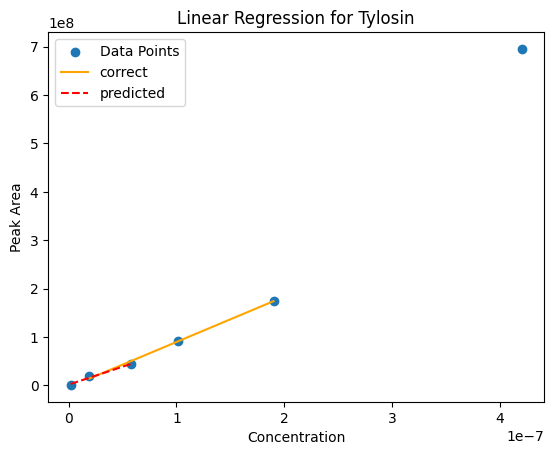

In [ ]:
# Visualization of results per one chemical data group
# Raises an error when the model doesn't predict any linear area, choose another index for result_groups[index]
group = result_groups[6]
threshold = 1e-5
winner = select_winner(group, threshold)
pred_start, pred_end = winner["start"], winner["end"]
compound_data = compound_datas[winner["compound"] + winner["lab"]]
plt.scatter(compound_data['c_real_M'], compound_data['peak_area'], label='Data Points')

def line(x, slope, intercept):
    return slope * x + intercept

real_lin_points = compound_data[compound_data["note"] == "linear"]
if len(real_lin_points["c_real_M"]) > 1 and len(real_lin_points["c_real_M"]) > 1:
    _, real_slope, real_intercept, _ = linear_regression(real_lin_points["c_real_M"].values.reshape(-1, 1), real_lin_points["peak_area"])
    min_x = real_lin_points["c_real_M"].min()
    max_x = real_lin_points["c_real_M"].max()
    x_values = np.linspace(min_x, max_x, 100)
    y_values = [line(x, real_slope, real_intercept) for x in x_values]
    plt.plot(x_values, y_values, label=f"correct", color='orange')

pred_lin_points = compound_data[[True if pred_start <= j <= pred_end else False for j in range(len(compound_data))]]
if len(pred_lin_points["c_real_M"]) > 1 and len(pred_lin_points["c_real_M"]) > 1:
    _, pred_slope, pred_intercept, _ = linear_regression(pred_lin_points["c_real_M"].values.reshape(-1, 1), pred_lin_points["peak_area"])
    min_x = pred_lin_points["c_real_M"].min()
    max_x = pred_lin_points["c_real_M"].max()
    x_values = np.linspace(min_x, max_x, 100)
    y_values = [line(x, pred_slope, pred_intercept) for x in x_values]
    plt.plot(x_values, y_values, label=f"predicted", color='red', linestyle='dashed')

#plt.plot(line_X, line_y, color='red', label=f'Linear Regression (MSE: {mse:.2f})')
plt.xlabel('Concentration')
plt.ylabel('Peak Area')
plt.title(f'Linear Regression for {winner["compound"]}')
plt.legend()
plt.show()